In [1]:
import polars as pl
import pandas as pd
import numpy as np 
from pathlib import Path
from tqdm import tqdm
import arviz as az 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import rdrobust
import rddensity
from io import BytesIO
from datetime import datetime
from rdrobust import rdrobust, rdplot
import warnings, base64, os
warnings.filterwarnings("ignore")

random_seed = 123
rng = np.random.default_rng(random_seed)

In [32]:
def process_parquet_folder_RDD(
    folder_path: str, 
    treatment_area: int = 92011,
    date_base: int = 202104,  # baseline policy month (YYYYMM)
    age_base: int = 16,        # Cohort of this RDD
    Y: str = "ika_out_req_amt"
) -> pl.DataFrame:
    """
    Process Parquet files (treatment area only) for RDD analysis.
    
    Steps:
        1. Compute baseline age (float) using correct formula
        2. Keep patients aged <19 at baseline
        3. Compute current age (float) using correct formula
        4. Compute Δ1 (±1 month) and Δ2 (±2 months) flags based on age_base
        5. Adjust birth_date: people in Delta1 get mapped to "center" birth month
        6. Recalculate age_adjusted using adjusted birth_date
        7. Keep only treatment area
        8. Flag D=1 for patients who used public expense after policy
        9. Keep only D=1 and Δ1 samples
    """

    parquet_dir = Path(folder_path)
    parquet_files = list(parquet_dir.glob("*.parquet"))
    if not parquet_files:
        raise FileNotFoundError(f"No parquet files found in {folder_path}")

    print(f"Processing treatment area: {treatment_area}")
    print(f"Baseline: {date_base}, RDD age_base: {age_base}\n")

    merged_results = []

    # ─────────────────────────────────────────────
    # Process all parquet files
    # ─────────────────────────────────────────────
    for parquet in tqdm(parquet_files, desc="Processing Parquet Files"):
        lf = pl.scan_parquet(parquet)

        # 性別・家族区分 → 数値化
        lf = lf.with_columns([
            pl.when(pl.col("sex_type_nm") == "男").then(0)
              .when(pl.col("sex_type_nm") == "女").then(1)
              .otherwise(None)
              .alias("sex_type_nm").cast(pl.Float64),
            pl.when(pl.col("rezept_family_type_nm") == "家族").then(0)
              .when(pl.col("rezept_family_type_nm") == "本人").then(1)
              .otherwise(None)
              .alias("rezept_family_type_nm").cast(pl.Float64)
        ])

        # 職業・年収カテゴリ変換
        lf = lf.with_columns([
            pl.col("business_type").cast(pl.Categorical).to_physical().alias("business_type_num"),
            pl.col("annual_salary_rank").cast(pl.Categorical).to_physical().alias("annual_salary_rank_num")
        ])

        # ═════════════════════════════════════════════════════════════
        # AGE CALCULATIONS - CORRECTED FORMULA
        # ═════════════════════════════════════════════════════════════
        
        # Step 1: Baseline age (at date_base) using ORIGINAL birth_date
        lf = lf.with_columns([
            (
                (date_base // 100 - pl.col("birth_date") // 100)
                + ((date_base % 100 - pl.col("birth_date") % 100) / 12.0)
            ).cast(pl.Float64).alias(f"age_at_{date_base}")
        ])

        lf = lf.filter((pl.col(f"age_at_{date_base}") >= 0) & (pl.col(f"age_at_{date_base}") <= 25))

        # Step 2: Current age using ORIGINAL birth_date
        lf = lf.with_columns([
            (
                (pl.col("medtreat_yymm") // 100 - pl.col("birth_date") // 100)
                + ((pl.col("medtreat_yymm") % 100 - pl.col("birth_date") % 100) / 12.0)
            ).cast(pl.Float64).alias("age")
        ])

        df_all = lf.collect()

        # ─────────────────────────────────────────────
        # Dominant area check
        # ─────────────────────────────────────────────
        area_counts = (
            df_all.group_by(["patient_id", "area_id"])
            .agg(pl.len().alias("visits"))
        )
        dominant_area = (
            area_counts.sort(["patient_id", "visits"], descending=[False, True])
            .group_by("patient_id")
            .agg(pl.first("area_id").alias("area_id"))
        )

        # ─────────────────────────────────────────────
        # Marking those "in the treatment area"
        # ─────────────────────────────────────────────
        eligible_patients = (
            dominant_area.filter(pl.col("area_id") == treatment_area)
            .select("patient_id")
            .with_columns(pl.lit(1).alias("D"))
        )

        # Join & keep D=1 only
        df_treat = (
            df_all.join(eligible_patients, on="patient_id", how="left")
            .with_columns(pl.col("D").fill_null(0))
            .join(dominant_area.select(["patient_id","area_id"]), on = "patient_id", how = "left")
            .with_columns(
                (pl.col("area_id") == treatment_area)
                .cast(pl.Int8)
                .alias(f"Base_{treatment_area}")
            )
            .filter(pl.col("D") == 1)
        )
        
        merged_results.append(df_treat)

    # ─────────────────────────────────────────────
    # Combine all files
    # ─────────────────────────────────────────────
    final_df = pl.concat(merged_results, how="vertical_relaxed")
    
    # Select relevant columns
    final_df = final_df.select([
        'patient_id', 'D', Y, 'birth_date', f'age_at_{date_base}',
        'medtreat_yymm', 'age', 'sex_type_nm',
        'rezept_family_type_nm', 'business_type_num',
        'annual_salary_rank_num', 'area_id', f'Base_{treatment_area}'
    ])
    # ─────────────────────────────────────────────
    # Summary statistics
    # ─────────────────────────────────────────────
    print(f"\n✅ Completed {len(parquet_files)} files")
    print(f"Total rows (D=1 only): {final_df.height:,}")
    print(f"Unique patients: {final_df['patient_id'].n_unique():,}")

    return final_df

In [33]:
df_rdd = process_parquet_folder_RDD("/Users/lex/CodeProjects/MyProject/Mitaron/Parquet_fresh")
# df_rdd.write_csv("rdd_input.csv")
df_rdd

Processing Parquet Files: 100%|██████████| 8/8 [00:01<00:00,  7.94it/s]


patient_id,D,ika_out_req_amt,birth_date,age_at_202104,medtreat_yymm,age,sex_type_nm,rezept_family_type_nm,business_type_num,annual_salary_rank_num,area_id,Base_92011
str,i32,i64,i64,f64,i64,f64,f64,f64,u32,u32,i32,i8
"""RI0010275446""",1,40580,202011,0.416667,202309,2.833333,0.0,0.0,2,0,92011,1
"""RI0008635865""",1,28010,200101,20.25,202103,20.166667,0.0,0.0,3,1,92011,1
"""RI0011158736""",1,6530,200512,15.333333,202504,19.333333,1.0,1.0,2,0,92011,1
"""RI0006087430""",1,6870,200204,19.0,202203,19.916667,0.0,0.0,3,1,92011,1
"""RI0003353131""",1,15600,201510,5.5,201908,3.833333,1.0,0.0,3,1,92011,1
…,…,…,…,…,…,…,…,…,…,…,…,…
"""RI0005913138""",1,18140,202011,0.416667,202112,1.083333,0.0,0.0,0,11,141003,0
"""RI0001619834""",1,3700,200505,15.916667,202408,19.25,1.0,0.0,2,13,141003,0
"""RI0007925260""",1,10980,200411,16.416667,202505,20.5,0.0,0.0,2,13,141003,0


In [34]:
def run_full_rdd_analysis(final_df, age_base=16, date_base=202104):
    """
    Run full RDD + Placebo (age±1) analysis and save an HTML report.
    """

    # === 1️⃣ Ask for HTML title ===
    html_title = input("Enter HTML report title (e.g. RDD_Age19_Analysis): ").strip()
    if not html_title:
        html_title = f"RDD_Analysis_Age{age_base}"

    # === 2️⃣ Data prep ===
    np.random.seed(4)
    df_rdd = final_df.clone() if isinstance(final_df, pl.DataFrame) else pl.from_pandas(final_df)

    df_rdd = df_rdd.with_columns([
        (pl.col(f"age_at_{date_base}") - age_base).alias("running_var"),
        (pl.col(f"age_at_{date_base}") < age_base).cast(pl.Int8).alias("treated")
    ])

    # Local window ±3 years
    df_local = df_rdd.filter(
        (pl.col(f"age_at_{date_base}") >= age_base - 3.5) &
        (pl.col(f"age_at_{date_base}") <= age_base + 3.5)
    )
    pdf = df_local.select(["running_var", "treated", "ika_out_req_amt"]).to_pandas()
    pdf = pdf.dropna().reset_index(drop=True)  # 🔧 FIX: Remove NaN values
    Y = "ika_out_req_amt"

    # === 3️⃣ Winsorize + log transform ===
    q_low, q_high = pdf[Y].quantile([0.01, 0.99])
    pdf["Y_winsor"] = pdf[Y].clip(q_low, q_high)
    pdf["Y_log_win"] = np.log1p(pdf["Y_winsor"])

    # === 4️⃣ Save distribution comparison ===
    fig_dist, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].hist(pdf[Y], bins=100, color="gray", alpha=0.7)
    axes[0].set_title("Original Y (ika_out_req_amt)")
    axes[0].set_xlabel("¥ (yen)")
    axes[1].hist(pdf["Y_winsor"], bins=100, color="orange", alpha=0.7)
    axes[1].set_title("Winsorized (top 1%)")
    axes[1].set_xlabel("¥ (yen)")
    axes[2].hist(pdf["Y_log_win"], bins=100, color="steelblue", alpha=0.7)
    axes[2].set_title("log(1 + Winsorized Y)")
    axes[2].set_xlabel("log(1 + ¥)")
    plt.tight_layout()
    buf_dist = BytesIO()
    fig_dist.savefig(buf_dist, format="png", dpi=100, bbox_inches="tight")
    buf_dist.seek(0)
    dist_base64 = base64.b64encode(buf_dist.read()).decode("utf-8")
    plt.close(fig_dist)

    # === 5️⃣ Continuity plot ===
    # ================================================================
    # 🧩 CONTINUITY CHECK — 10 Subparts
    # ================================================================

    # === 1️⃣ Define binning resolution (here: monthly = 1/12 year) ===
    bin_size = 1 / 12

    # === 2️⃣ Create binned running variable ===
    pdf["bin_cont"] = (pdf["running_var"] / bin_size).round() * bin_size

    # === 3️⃣ Aggregate counts per bin ===
    bin_counts = (
        pdf.groupby("bin_cont")
        .size()
        .reset_index(name="count")
        .sort_values("bin_cont")
    )

    # === 4️⃣ Create figure and axes ===
    fig_cont, ax = plt.subplots(figsize=(8, 4.5))

    # === 5️⃣ Scatter plot of binned counts ===
    ax.scatter(
        bin_counts["bin_cont"], bin_counts["count"],
        s=40, color="tomato", marker="D", alpha=0.7, label="Binned Counts"
    )

    # === 6️⃣ Fit 2nd-order polynomial smoothing line ===
    sns.regplot(
        data=bin_counts, x="bin_cont", y="count",
        scatter=False, order=2, color="black", ci=None, ax=ax, label="Polynomial Fit"
    )

    # === 7️⃣ Add vertical line at cutoff (0) ===
    ax.axvline(0, color="black", linestyle="--", linewidth=1.2, label="Eligibility Loss (Cutoff)")

    # === 8️⃣ Add labels and formatting ===
    ax.set(
        title="Continuity Check: Distribution Around Eligibility Loss",
        xlabel="Years from Eligibility Loss (Running Variable)",
        ylabel="Number of Observations"
    )
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()

    # === 9️⃣ Save to memory buffer (for HTML embedding) ===
    buf_cont = BytesIO()
    fig_cont.savefig(buf_cont, format="png", dpi=100, bbox_inches="tight")
    buf_cont.seek(0)

    # === 🔟 Encode figure as base64 string for embedding ===
    cont_base64 = base64.b64encode(buf_cont.read()).decode("utf-8")
    plt.close(fig_cont)



    # === 6️⃣ RDD Mean Plot ===
    pdf["bin"] = (pdf["running_var"] * 10).round() / 12
    binned = pdf.groupby(["bin", "treated"])["Y_log_win"].mean().reset_index()
    fig_rdd, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(data=binned, x="bin", y="Y_log_win", hue="treated",
                    palette=["tab:green", "royalblue"], s=60, alpha=0.9, ax=ax)
    sns.regplot(data=pdf[pdf["running_var"] < 0], x="running_var", y="Y_log_win",
                scatter=False, color="tab:green", order=1, ax=ax)
    sns.regplot(data=pdf[pdf["running_var"] >= 0], x="running_var", y="Y_log_win",
                scatter=False, color="royalblue", order=1, ax=ax)
    ax.axvline(0, color="tomato", linestyle="--", linewidth=1.5)
    ax.set(title=f"RDD Mean Plot: log(Medical Expenditure) around Age {age_base}",
           xlabel=f"Age − {age_base} (Running Variable)", ylabel="log(1 + Medical Expenditure)")
    ax.legend(title="Treated (Eligible)", labels=[f"Control (≥ {age_base})", f"Treated (< {age_base})"])
    ax.grid(alpha=0.3)
    plt.tight_layout()
    buf_rdd = BytesIO()
    fig_rdd.savefig(buf_rdd, format="png", dpi=100, bbox_inches="tight")
    buf_rdd.seek(0)
    rdd_base64 = base64.b64encode(buf_rdd.read()).decode("utf-8")
    plt.close(fig_rdd)

    # === 7️⃣ Nonparametric RDD and Placebos ===
    figs_base64 = []
    cutoffs = [0, -1, +1]

    print("\n" + "="*70)
    print("Running RDD Analysis at Multiple Cutoffs")
    print("="*70)

    for c in cutoffs:
        cutoff_label = f"Age {age_base + c}"
        print(f"Processing cutoff: {cutoff_label}")

        # 🔧 FIX: rdplot returns an rdplot_output object with ggplot
        result = rdplot(
            y=pdf['Y_log_win'].values,
            x=pdf['running_var'].values,
            c=c,
            title=f"RDD Plot: Medical Expenditure at {cutoff_label} Cutoff",
            x_label=f"Age − {age_base} (Running Variable)",
            y_label="log(1 + Medical Expenditure)",
            binselect="es"
        )

        # Save the ggplot object to buffer
        buf = BytesIO()
        result.rdplot.save(buf, format="png", dpi=100, verbose=False)
        buf.seek(0)
        figs_base64.append((c, base64.b64encode(buf.read()).decode("utf-8")))

    # === 8️⃣ Run rdrobust for statistics (print-style summaries only) ===
    cutoffs = [0, -1, +1]
    rdd_texts = []  # store full string summaries for HTML
    print("\n" + "="*70)
    print("Running rdrobust estimation for all cutoffs...")
    print("="*70)

    for c in cutoffs:
        cutoff_age = age_base + c
        result = rdrobust(
            y=pdf['Y_log_win'].values,
            x=pdf['running_var'].values,
            c=c,
            all=True
        )

        # Capture printed output (like the original style)
        from io import StringIO
        import sys
        buffer = StringIO()
        sys.stdout = buffer
        print(f"\n=== RDD Results for Age {cutoff_age} Cutoff ===")
        print(result)
        sys.stdout = sys.__stdout__
        rdd_texts.append((cutoff_age, buffer.getvalue()))

    # Combine all text summaries into one HTML section
    rdd_html_blocks = ""
    for cutoff_age, text_output in rdd_texts:
        rdd_html_blocks += f"""
        <h3>RDD Results: Age {cutoff_age} Cutoff</h3>
        <pre style="background:#f8f9fa; border:1px solid #ccc; padding:10px; white-space:pre-wrap;">
{text_output}
        </pre>
        """

    # === 9️⃣ Build HTML ===
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    output_dir = "Mitaron/RDD_Results"
    os.makedirs(output_dir, exist_ok=True)
    file_path = f"{output_dir}/{html_title}_{timestamp}.html"

    html = f"""
    <!DOCTYPE html>
    <html><head><meta charset='utf-8'><title>{html_title}</title>
    <style>
      body {{ font-family: Arial, sans-serif; margin: 40px; background-color: #f8f9fa; }}
      h1 {{ text-align:center; border-bottom:3px solid #2c7be5; color: #2c3e50; }}
      h2 {{ border-left:5px solid #2c7be5; padding-left:10px; color: #34495e; margin-top: 30px; }}
      h3 {{ color: #7f8c8d; margin-top: 20px; }}
      img {{ display:block; margin:auto; border: 1px solid #ddd; padding: 10px; background: white; }}
      table {{ margin: 20px auto; border-collapse: collapse; box-shadow: 0 2px 4px rgba(0,0,0,0.1); }}
      th, td {{ padding: 10px 15px; text-align: left; border: 1px solid #ddd; }}
      th {{ background-color: #2c7be5; color: white; }}
      tr:nth-child(even) {{ background-color: #f2f2f2; }}
      .info-box {{ background: #e3f2fd; padding: 15px; border-left: 4px solid #2196f3; margin: 20px 0; }}
      .timestamp {{ text-align: center; color: #7f8c8d; font-size: 0.9em; }}
    </style></head><body>
    <h1>📊 {html_title}</h1>
    <p class="timestamp">Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>

    <div class="info-box">
    <strong>Analysis Summary:</strong><br>
    • Sample Size: {len(pdf):,}<br>
    • Cutoff Age: {age_base}<br>
    • Running Variable Range: [{pdf['running_var'].min():.2f}, {pdf['running_var'].max():.2f}]<br>
    • Outcome: log(1 + Medical Expenditure)
    </div>

    <h2>1. Data Transformation</h2>
    <p>To handle outliers and skewness: (1) Winsorization at 1st and 99th percentiles, (2) Log transformation.</p>
    <img src="data:image/png;base64,{dist_base64}" style="width:95%;max-width:900px;">

    <h2>2. Continuity Check (McCrary Test)</h2>
    <p>Testing for manipulation around the cutoff. A smooth distribution suggests no manipulation.</p>
    <img src="data:image/png;base64,{cont_base64}" style="width:90%;max-width:800px;">

    <h2>3. RDD Mean Plot (Local Linear)</h2>
    <p>Visual evidence of discontinuity at the cutoff using binned means and local linear regression.</p>
    <img src="data:image/png;base64,{rdd_base64}" style="width:90%;max-width:800px;">

    <h2>4. RDD Estimates (Full Output)</h2>
    <p>Below are the complete <code>rdrobust</code> summaries for the main and placebo cutoffs.</p>
    {rdd_html_blocks}

    <h2>5. Nonparametric RDD Plots (rdrobust.rdplot)</h2>

    <h3>Main Analysis: Age {age_base} Cutoff</h3>
    <p><strong>This is the main treatment effect.</strong> A visible discontinuity indicates a causal effect.</p>
    <img src="data:image/png;base64,{figs_base64[0][1]}" style="width:90%;max-width:800px;">

    <h3>Placebo Test: Age {age_base - 1} Cutoff</h3>
    <p><strong>Placebo test below the true cutoff.</strong> Should show NO discontinuity if RDD is valid.</p>
    <img src="data:image/png;base64,{figs_base64[1][1]}" style="width:90%;max-width:800px;">

    <h3>Placebo Test: Age {age_base + 1} Cutoff</h3>
    <p><strong>Placebo test above the true cutoff.</strong> Should show NO discontinuity if RDD is valid.</p>
    <img src="data:image/png;base64,{figs_base64[2][1]}" style="width:90%;max-width:800px;">

    <h2>6. Interpretation</h2>
    <div class="info-box">
    <strong>Key Findings:</strong><br>
    <br>
    <strong>✓ Valid RDD if:</strong> Main effect is significant, placebos are not.
    </div>

    <p style="text-align:center;margin-top:40px;color:#7f8c8d;">✅ Report saved at: <code>{file_path}</code></p>
    </body></html>
    """

    with open(file_path, "w", encoding="utf-8") as f:
        f.write(html)

    print("="*70)
    print(f"✅ RDD Report generated: {file_path}")
    print("="*70)

    return file_path

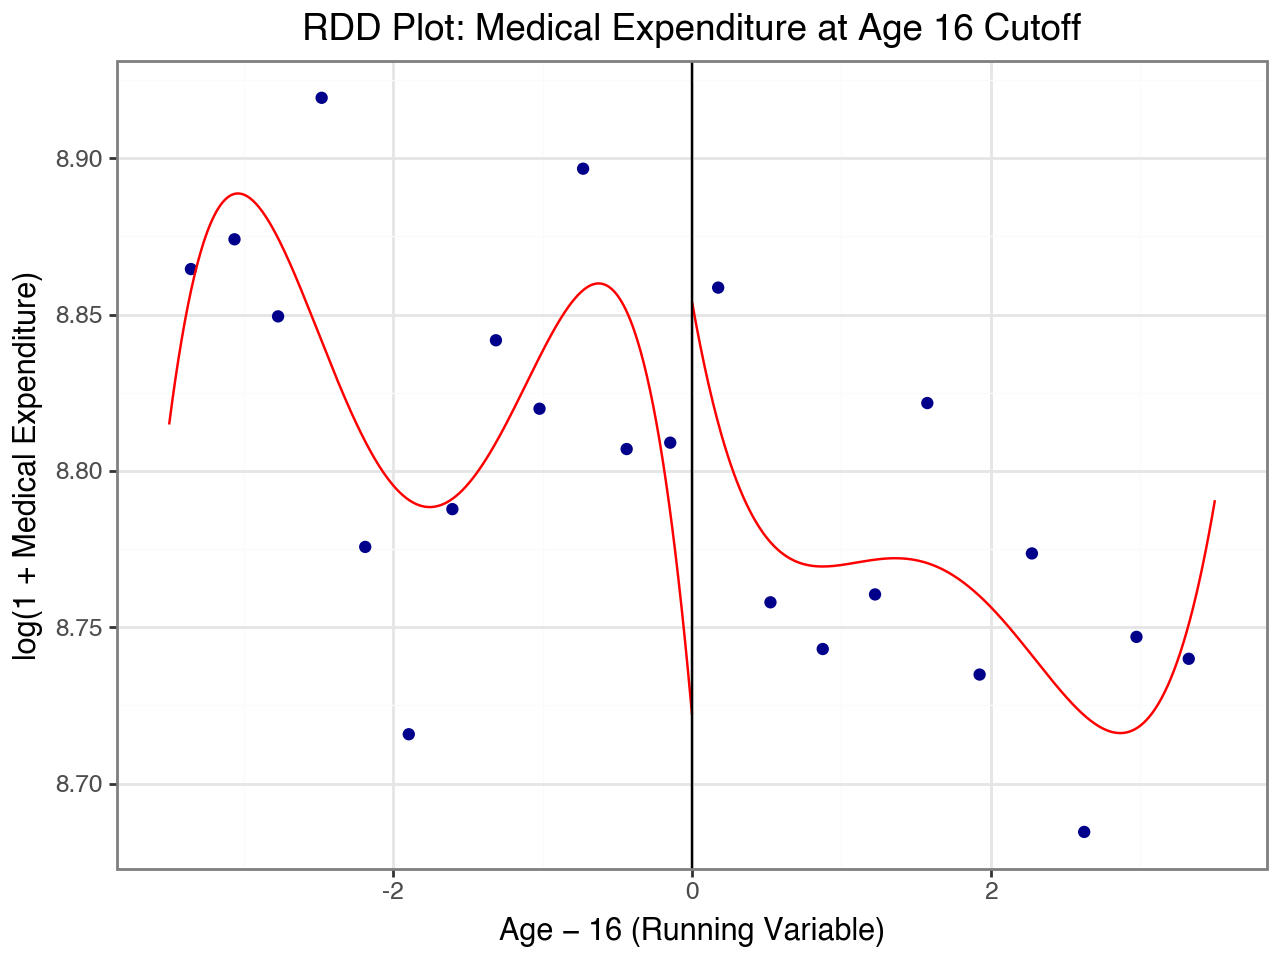

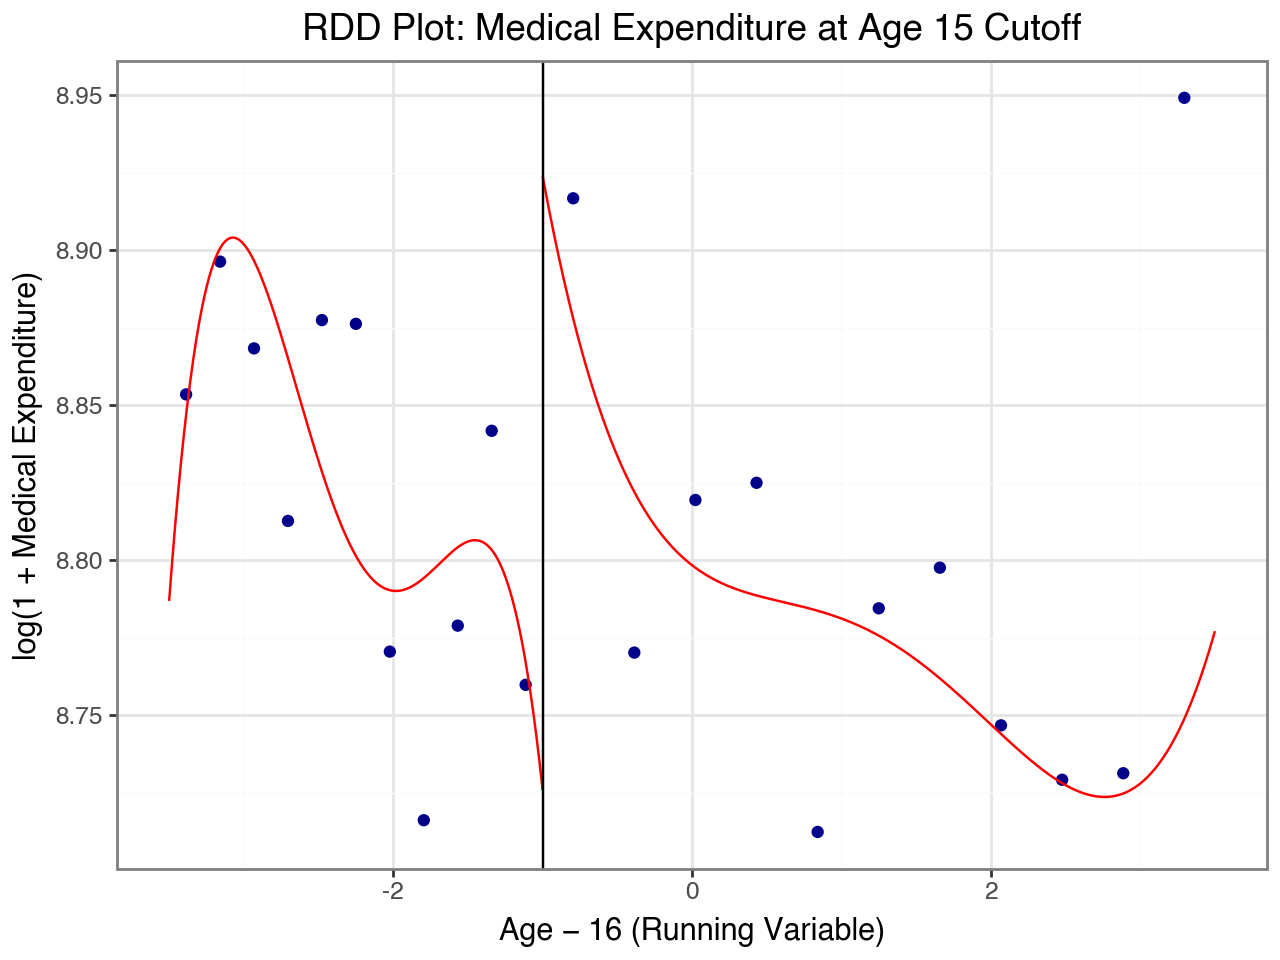

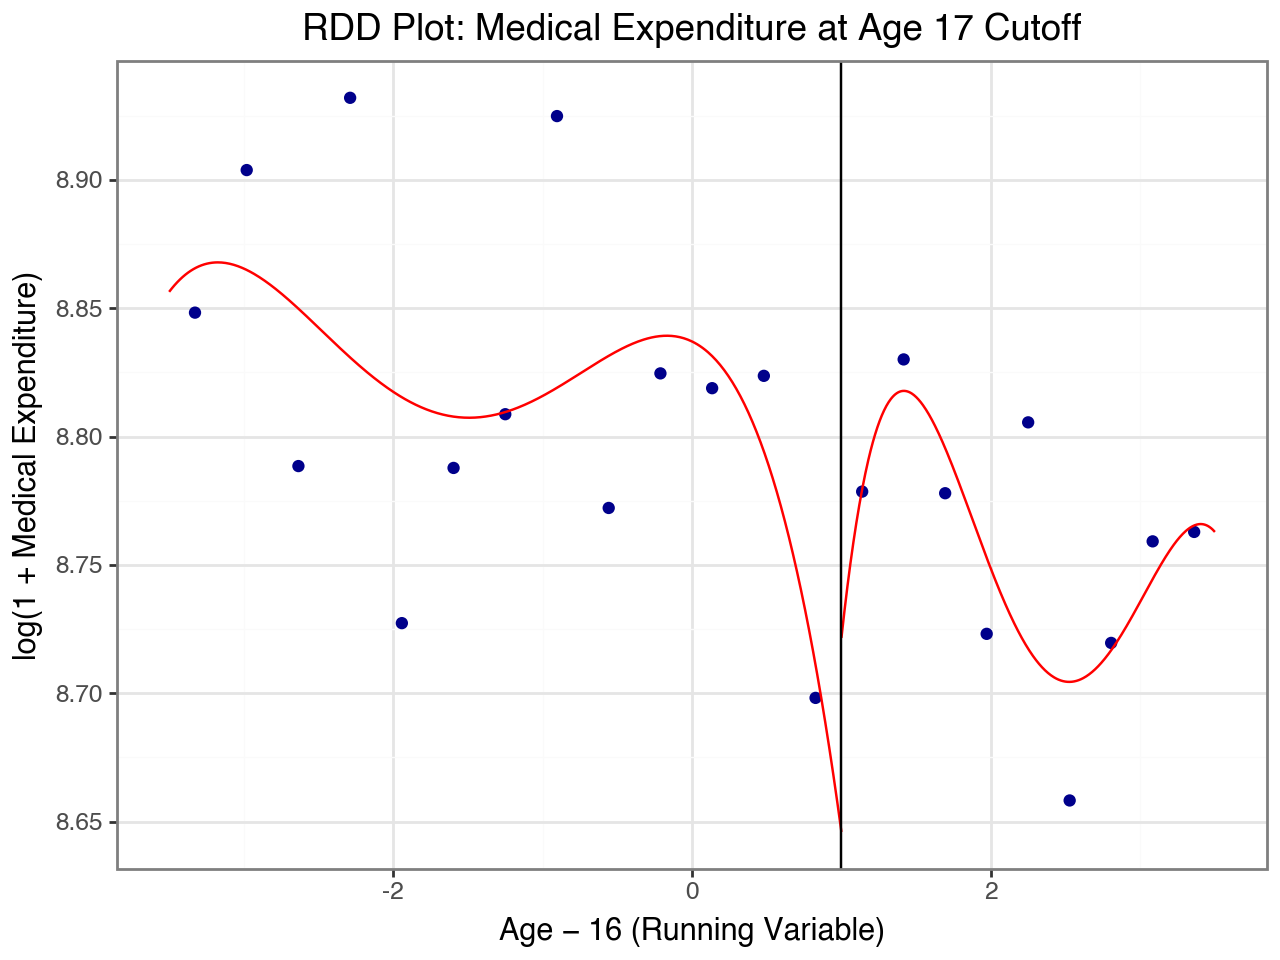

'Mitaron/RDD_Results/RDD_16_Utsunomiya_20251110_0415.html'

In [35]:
run_full_rdd_analysis(df_rdd)